<a href="https://colab.research.google.com/github/mr-nudo/intelligent-tools/blob/master/8b_Kaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
file_path = '/content/train.csv'  # Replace with the actual file path
data = pd.read_csv(file_path)
output_size = 3

# Separate features and labels
X = data.drop(columns=['Label', 'ID']).values  # Features
y = data['Label'].values  # Labels

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

def check_and_fix_labels(dataset):
    for i in range(len(dataset)):
        label = dataset[i][1]  # Assuming labels are the second element in your dataset items
        if label < 0 or label >= output_size:
            print(f"Invalid label found at index {i}: {label}. Replacing with 0.")
            dataset[i][1] = 0  # Replace invalid labels with a default value (0 in this case)

# Check and fix labels in the datasets
check_and_fix_labels(train_dataset)
check_and_fix_labels(val_dataset)
check_and_fix_labels(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset and loader info
print(f'Training set: {len(train_loader.dataset)} samples')
print(f'Validation set: {len(val_loader.dataset)} samples')
print(f'Test set: {len(test_loader.dataset)} samples')

Training set: 2862 samples
Validation set: 613 samples
Test set: 614 samples


In [4]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_nodes, output_size):
        super(SimpleNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_nodes[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_nodes[i-1], hidden_nodes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_nodes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define the model structures
structures = [
    {'hidden_layers': 1, 'hidden_nodes': [64]},
    {'hidden_layers': 2, 'hidden_nodes': [32, 32]},
    {'hidden_layers': 2, 'hidden_nodes': [64, 64]}
]

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, unsqueeze=False):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            if unsqueeze:
              inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if unsqueeze:
                  inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    return train_losses, val_losses


In [6]:
def evaluate_model(model, test_loader, unsqueeze=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if unsqueeze:
              inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    return accuracy, class_report


In [7]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


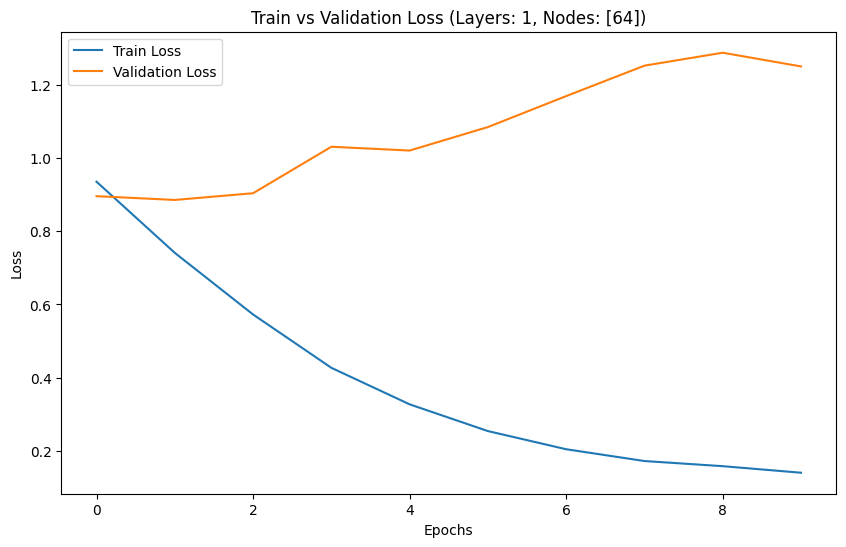

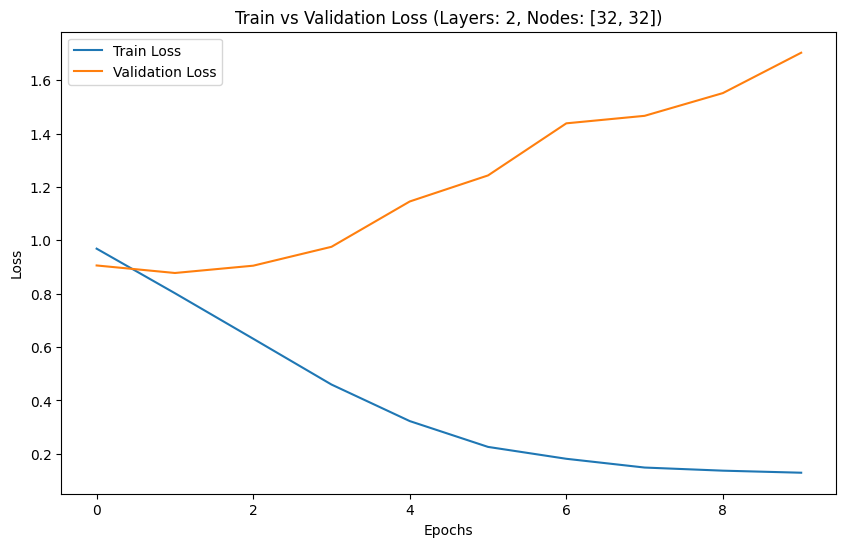

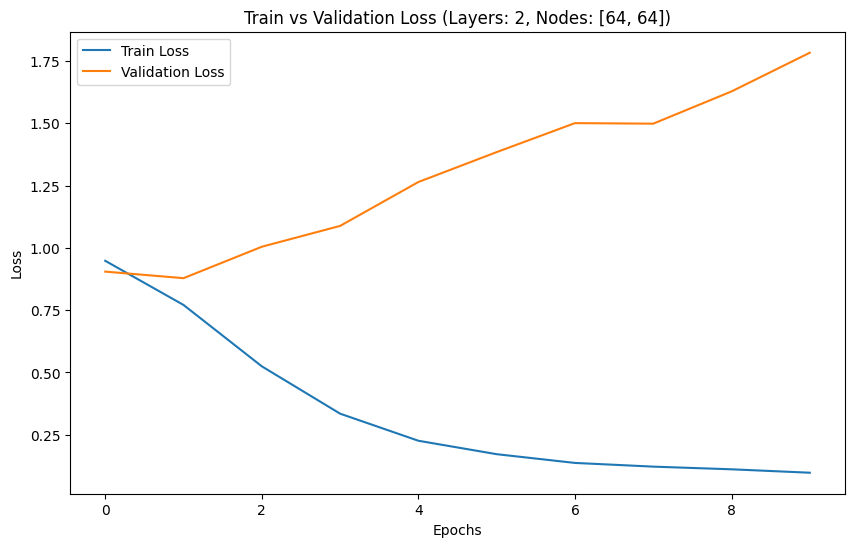

Structure: {'hidden_layers': 1, 'hidden_nodes': [64]}
Accuracy: 0.5700325732899023
Class-wise Accuracy and F1 Scores:
{'0': {'precision': 0.2542372881355932, 'recall': 0.3409090909090909, 'f1-score': 0.2912621359223301, 'support': 88.0}, '1': {'precision': 0.7083333333333334, 'recall': 0.6424418604651163, 'f1-score': 0.6737804878048781, 'support': 344.0}, '2': {'precision': 0.5380434782608695, 'recall': 0.5439560439560439, 'f1-score': 0.540983606557377, 'support': 182.0}, 'accuracy': 0.5700325732899023, 'macro avg': {'precision': 0.500204699909932, 'recall': 0.5091023317767503, 'f1-score': 0.502008743428195, 'support': 614.0}, 'weighted avg': {'precision': 0.5927743665571289, 'recall': 0.5700325732899023, 'f1-score': 0.5795937657320615, 'support': 614.0}}


Structure: {'hidden_layers': 2, 'hidden_nodes': [32, 32]}
Accuracy: 0.5993485342019544
Class-wise Accuracy and F1 Scores:
{'0': {'precision': 0.22727272727272727, 'recall': 0.22727272727272727, 'f1-score': 0.22727272727272727, 'supp

In [8]:
input_size = 30000  # Assuming 30000 features as per the dataset provided
output_size = 3  # Assuming 3 classes as per the Label column

learning_rate = 0.001
epochs = 100
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

results = []

for structure in structures:
    model = SimpleNN(input_size, structure['hidden_layers'], structure['hidden_nodes'], output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    accuracy, class_report = evaluate_model(model, test_loader)

    results.append({
        'structure': structure,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracy': accuracy,
        'class_report': class_report
    })

    title = f"Train vs Validation Loss (Layers: {structure['hidden_layers']}, Nodes: {structure['hidden_nodes']})"
    plot_losses(train_losses, val_losses, title)

# Print results
for result in results:
    structure = result['structure']
    print(f"Structure: {structure}")
    print(f"Accuracy: {result['accuracy']}")
    print("Class-wise Accuracy and F1 Scores:")
    print(result['class_report'])
    print("\n")


# Custom Model

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3750, 256)  # Adjust the dimension based on the input size
        self.fc2 = nn.Linear(256, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
input_size = 30000  # Assuming 30000 features as per the dataset provided
output_size = 3  # Assuming 3 classes as per the Label column
input_channels = 1

learning_rate = 0.001
epochs = 100
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize and train the model
model = CustomCNN(input_channels=input_channels, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, unsqueeze=True)
accuracy, class_report = evaluate_model(model, test_loader, unsqueeze=True)

# Plot losses
title = "Train vs Validation Loss (Custom CNN Model)"
plot_losses(train_losses, val_losses, title)

# Print results
print(f"Accuracy: {accuracy}")
print("Class-wise Accuracy and F1 Scores:")
print(class_report)